In [ ]:
%load_ext autoreload
%autoreload 2
import torch
from train_cnn import *

from loaddata import *
import pandas as pd

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 100

In [10]:
model = ConvNet(encoder='resnet50', outputs=16).to(DEVICE)
model.load_state_dict(torch.load('./model/resnet/best_epoch35_0.9706.pt'))
model.eval()
model.training

ConvNet(
  (enc): ResNet50Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): EncoderBottleneckBlock(
      (00 MaxPooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (01 EncoderLayer): EncoderBottleneckLayer(
        (weight_layer1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (weight_layer2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (weight_layer3): Sequen

In [11]:
d_idx2name = {}
with open('./data/imagenet-16/imagenet-16-train_name.txt') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        d_idx2name[int(parts[0])] =  parts[1] # idx --> name 
        
d_name2idx = {}
with open('./data/imagenet-16/imagenet-16-train_name.txt') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        d_name2idx[parts[1]] =  int(parts[0]) # idx --> name 

# extract features from imagenet augmented images

In [12]:
# ! pip install albumentations
# ! pip install --upgrade typing_extensions 

# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.4.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.
# tensorflow-gpu 2.4.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.
# Successfully installed typing_extensions-4.4.0

In [13]:
# for name, module in model.named_modules():
#     print(name)

## extract features and analyze RDM

In [14]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import pairwise_distances


from PIL import Image
from torchvision.transforms import transforms


val_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
              ])
    
    
def load_imgnames(imagefilelist, category):
    img_names = []
    with open(imagefilelist, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip().split(' ')
            if data[1] == category:
                img_names.append(data[0])
    return img_names


def load_images(img_names):
    
    imgs=[]
    for img in img_names:
        img = Image.open(img).convert('RGB') 
        if img is None:
            print(im_name)
            
        img = val_trans(img)
        imgs.append(img)
        
    return imgs

d_result= {}

In [15]:

# expname = 'exp_size'
for expname in ['exp_size', 'exp_position', 'exp_stats', 'exp_sf']:
    print(expname)
    categories = list(d_name2idx.keys())
    feature_name = ['block1', 'block2', 'block3', 'block4', 'primary', 'object']
    DISTANCE_METRIC = 'euclidean' #'euclidean'
    visualize_rdm= False

    d_rdm = defaultdict(dict)

    for ci, condition in enumerate(['original', 'transform']):
        print("\n\n\n=========> condition:", condition)
        d_features = defaultdict(dict)

        for category in categories:

            print('\n===start', category)

            # load images
            imagefilelist = f'./data/imagenet-16/imagenet-16-val-aug_{expname}_{condition}_list.txt'
            img_names = load_imgnames(imagefilelist, category)
            imgs = load_images(img_names)

            # register hooks for feature extraction
            features = []

            def get_outputs():
                def hook(model, input, output):
                    features.append(output.detach())
                return hook

            hook1 = model.enc.conv2.register_forward_hook(get_outputs())
            hook2 = model.enc.conv3.register_forward_hook(get_outputs())
            hook3 = model.enc.conv4.register_forward_hook(get_outputs())
            hook4 = model.enc.conv5.register_forward_hook(get_outputs())
            hook5 = model.avgpool.register_forward_hook(get_outputs())
            hook6 = model.fc.register_forward_hook((get_outputs()))

            # predict
            x = torch.stack(imgs).to(DEVICE)
            output = model(x)

            hook1.remove()
            hook2.remove()
            hook3.remove()
            hook4.remove()
            hook5.remove()
            hook6.remove()

            # accuracy
            topk_indices = output.topk(3, sorted=True)[1]
#             topk_indices = output.argmax(dim=1, keepdim=True) 

            if category in d_name2idx.keys():
                correct_idx = d_name2idx[category]
                correct_trial = [True if correct_idx in toklist else False for toklist in topk_indices]
            # topk_indices = list(topk_indices.flatten().cpu().numpy())
            # predictions = [d_idx2name[int(idx)] for idx in topk_indices]
            # print(predictions)
                print(f'start extraction on {category}, ', np.mean(correct_trial))
            else:
                print(f'start extraction on {category}, ', 'NA')
        #             if np.array(correct_trial).any() ==False:
        #                 print(category)
        #                 raise Error


            for i, f in enumerate(features):
            #     print(f.shape)
        #                 avg_f = f[correct_trial].mean(dim=0).cpu().numpy().flatten()
                avg_f = f.mean(dim=0).cpu().numpy().flatten()
            #     print(avg_f.shape)
                d_features[feature_name[i]][category] = avg_f.flatten()


        print('\n\n===start rdm analysis')

        for feature in feature_name:
            print('--on ', feature)
        #     feature = 'object'
            mat = []
            for cat in categories:
                mat.append(d_features[feature][cat])
            mat = np.array(mat)
            pdmat = pairwise_distances(mat, metric=DISTANCE_METRIC)

            d_rdm[feature][condition] = pdmat 

    # save data
    correlation= []
    for feature in feature_name:
        mats = []
        for condition in d_rdm[feature].keys():
            mats.append(d_rdm[feature][condition])


        c = spearmanr(mats[0].flatten(), mats[1].flatten())[0] #spearmanr
        correlation.append(c) 

        if visualize_rdm:
            plt.rcParams["figure.figsize"] = (14,5)
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle(f'layer: {feature}, correlation: {round(c,2)}')
            sns.heatmap(mats[0], annot=False, fmt=".2f", ax=ax1, xticklabels=categories, yticklabels=categories)
            sns.heatmap(mats[1], annot=False, fmt=".2f", ax=ax2, xticklabels=categories, yticklabels=categories)
            plt.show()

    d_result[expname] =correlation

exp_size



=========> condition: original

===start elephant
start extraction on elephant,  1.0

===start chair
start extraction on chair,  0.95

===start bicycle
start extraction on bicycle,  1.0

===start car
start extraction on car,  1.0

===start bird
start extraction on bird,  1.0

===start truck
start extraction on truck,  1.0

===start dog
start extraction on dog,  1.0

===start boat
start extraction on boat,  1.0

===start keyboard
start extraction on keyboard,  0.9

===start bottle
start extraction on bottle,  1.0

===start cat
start extraction on cat,  1.0

===start knife
start extraction on knife,  0.65

===start airplane
start extraction on airplane,  1.0

===start clock
start extraction on clock,  1.0

===start bear
start extraction on bear,  1.0

===start oven
start extraction on oven,  0.95


===start rdm analysis
--on  block1
--on  block2
--on  block3
--on  block4
--on  primary
--on  object



=========> condition: transform

===start elephant
start extraction on eleph

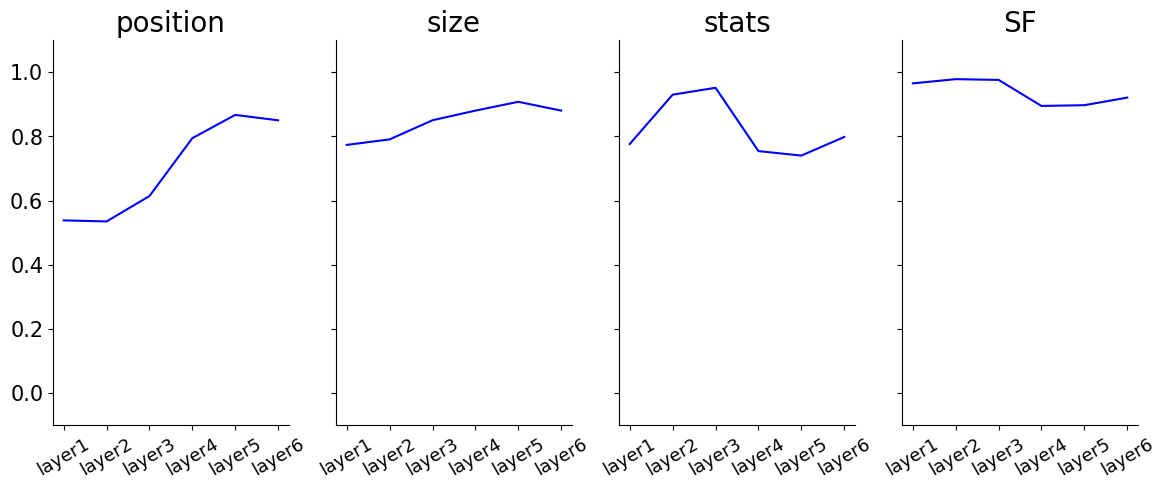

In [16]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (14,5)

N_COL = 4
fig, axes = plt.subplots(nrows=1, ncols=N_COL,  sharey=True)

x= ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
for i, exp in enumerate(['position', 'size', 'stats','SF']):
    axes[i].plot(x, d_result['exp_'+exp.lower()], 'blue')

    
#     axes[i].fill_between(x, y-error, y+error, alpha=0.1, facecolor='black')
    axes[i].set_title(exp, fontsize=20)
    axes[i].set_ylim(-0.1,1.1)
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=13, rotation=30)
    
plt.show()

In [17]:
import json
filename = 'resnet-euc-spearman-all'
with open(f'./results/imagenet-16/{filename}.json', 'w') as f:
    json.dump(d_result, f)